    eps  count_rmse  mean_rmse
0  0.05   27.893027  19.289506
1  0.10   14.043200  10.911106
2  0.20    7.401948   5.089116
3  0.50    2.997412   2.033475
4  1.00    1.382869   1.055268


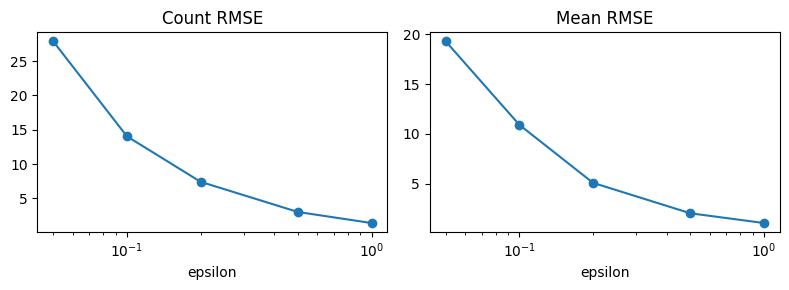

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
np.random.seed(0)

# --- utils ---
def lap(scale): return np.random.laplace(0, scale)
def dp_count(df, pred, eps):
    true = int(pred(df).sum()); scale = 1.0/eps
    noisy = max(0.0, true + lap(scale)); return noisy, true
def dp_mean(df, col, a, b, eps):
    x = df[col].clip(a, b).astype(float).values; n=len(x)
    true = x.mean(); delta = (b-a)/n; scale = delta/eps
    noisy = float(np.clip(true + lap(scale), a, b)); return noisy, true

# --- example data (Titanic) ---
t = sns.load_dataset('titanic').dropna(subset=['age','fare','sex','pclass','embarked'])
# queries
pred = lambda df: df['age'] > 30           # count query
col = 'fare'; a,b = 0.0, min(500, t['fare'].max())  # mean query bounds

# --- sweep eps and run trials ---
eps_list = [0.05, 0.1, 0.2, 0.5, 1.0]
T = 300
results = {'eps':[], 'count_rmse':[], 'mean_rmse':[]}

for eps in eps_list:
    # count trials
    noisy_counts = [dp_count(t, pred, eps)[0] for _ in range(T)]
    true_count = dp_count(t, pred, eps)[1]
    rmse_count = np.sqrt(np.mean((np.array(noisy_counts)-true_count)**2))
    # mean trials
    noisy_means = [dp_mean(t, col, a, b, eps)[0] for _ in range(T)]
    true_mean = dp_mean(t, col, a, b, eps)[1]
    rmse_mean = np.sqrt(np.mean((np.array(noisy_means)-true_mean)**2))
    results['eps'].append(eps); results['count_rmse'].append(rmse_count); results['mean_rmse'].append(rmse_mean)

res = pd.DataFrame(results)
print(res)

# --- simple plots ---
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(res.eps, res.count_rmse, marker='o'); plt.xscale('log'); plt.title('Count RMSE'); plt.xlabel('epsilon')
plt.subplot(1,2,2)
plt.plot(res.eps, res.mean_rmse, marker='o'); plt.xscale('log'); plt.title('Mean RMSE'); plt.xlabel('epsilon')
plt.tight_layout(); plt.show()
